<a href="https://colab.research.google.com/github/FrancoPalavicinoG/ML_courses/blob/main/notebooks/Tarea1_preprocessing_clasification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Laboratorio 1 - Pre-procesamiento de texto
#Curso Analítica Textual con Machine Learning

Profesora: Carla Vairetti

Los datos en el mundo real suelen **estar incompletos y tener inconsistencias**. Por esto, es necesario preparar los datos antes de ejecutar modelos de analítica.

En este primer laboratorio prepararemos datos de texto para que en los próximos laboratorios encontremos **patrones valiosos para la toma de decisiones**.

Primero es necesario **importar las librerías** con las que vamos a trabajar. Esto es necesario hacerlo siempre que queramos correr este código.

In [ ]:
import pandas as pd
import numpy as np
# NLTK (Natural Language ToolKit) es una libreria para NLP
import nltk
# Existe extensiones que debemos descargar
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from collections import defaultdict

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#LLamar a un archivo en Google Drive

El siguiente paso es montar Google Drive para poder enlazar nuestra base de datos. De esta forma podemos cargar después nuestra base de datos tripadvisor-rest5000.xlsx (que tenemos que tener en una carpeta “Colab Notebooks” en nuestro Drive claramente identificada).

Esta base de datos cuenta con comentarios de Tripadvisor de restaurants chilenos entre los años 2007 y 2015.

**Cuando corra la siguiente línea, siga las intrucciones indicando la cuenta de Google correspondiente y aceptando las condiciones.**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Una vez cargado nuestro drive, llamamos a nuestra base de datos:

In [ ]:
ruta_data_set = '/content/gdrive/MyDrive/202520/ANALITICA TEXTUAL/T1/COAH dataset.xlsx'
df = pd.read_excel(ruta_data_set)

Descripción de variables de la base de datos:

1.   **Titulo**: Título del comentario (ingresado por usuario).
2.   **Rating**: Nota otorgada por el usuario (del 1 al 5, con 5 mayor satisfacción).
3.   **Comentario**: Cuerpo del comentario (ingresado por usuario).
4.   **Dia**: Fecha de comentario.



In [ ]:
df.describe(include='all')

,id,rank,abstract,review
count,1816.000000,1816.000000,1816,1816
unique,NaN,NaN,1681,1792
top,NaN,NaN,Excelente,No entiendo esta mala fama q se le intenta cre...
freq,NaN,NaN,15,2
mean,908.500000,3.400881,NaN,NaN
std,524.378362,1.440875,NaN,NaN
min,1.000000,1.000000,NaN,NaN
25%,454.750000,2.000000,NaN,NaN
50%,908.500000,4.000000,NaN,NaN
75%,1362.250000,5.000000,NaN,NaN


# Análisis Exploratorio de Datos: Variable Objetivo

El AED consiste en **examinar los datos para entenderlos, ver relaciones entre variables y encontrar posibles inconsistencias**.

Para esto, se analiza estadística descriptiva y gráﬁcos.

Para analizar el comportamiento de los datos de la variable objetivo (rating), generamos un gráfico de barras.

rank
5    531
4    489
1    312
3    285
2    199
Name: count, dtype: int64


<Axes: xlabel='rank'>

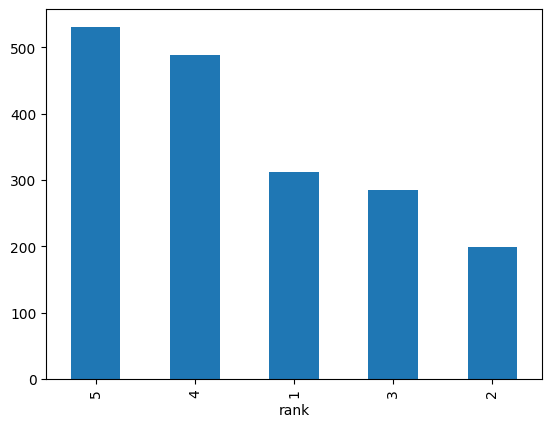

In [ ]:
print(df['rank'].value_counts())
df['rank'].value_counts().plot(kind='bar')

De la tabla y gráfico anterior, podemos **identificar inconsistencias** (*gif*), las cuales eliminaremos antes de seguir.

In [ ]:
# Verificamos que en Rating solo hay valores numericos, si no se cambia a Nan
df['rank'] = pd.to_numeric(df['rank'], errors='coerce')
df = df.dropna(subset=['rank'])
df

,id,rank,abstract,review
0,1,5,Un hotel digno de mención!,Como bien les comenté a los propietarios a la ...
1,2,4,"Recomendable 100%, sin lujos pero todo perfecto.","Estuvimos dos días con mi familia, reservando ..."
2,3,3,Decepción,Habíamos escogido este hotel por las buenas op...
3,4,5,"Por segunda vez, inmejorable",Hemos vuelto por segunda vez a este estupendo ...
4,5,5,No tan sorpresa,"He estado dos días en Granada por trabajo, soy..."
...,...,...,...,...
1811,1812,5,remanso de paz en el corazón de Córdoba,Hemos empezado el año con una estancia de tres...
1812,1813,5,"Oasis de paz, tranquilidad y belleza!",Al atravesar el umbral de la puerta que conduc...
1813,1814,5,Un lugar para recordar,En este hotel todo son sensaciones y experienc...
1814,1815,5,Extraordinario,Hemos pasado un par de noches en este exquisit...


Utilizaremos la definición clásica en análisis de sentimientos **recodificando** el rating en los siguientes valores:

1 y 2 -> 0 (Negativo)

3 -> 1 (Neutro)

4 y 5 -> 2 (Positivo)



rank
2    1020
0     511
1     285
Name: count, dtype: int64


<Axes: xlabel='rank'>

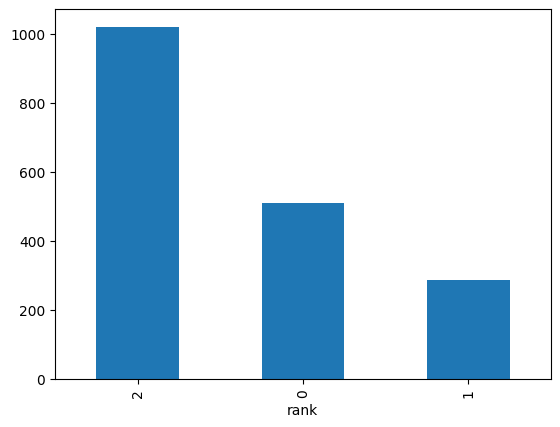

In [ ]:
df['rank'] = df['rank'].replace({1: 0, 2: 0, 3: 1, 4: 2, 5: 2})

# Imprimir y graficar la distribucion de los ratings simplificados
print(df['rank'].value_counts())
df['rank'].value_counts().plot(kind='bar')

# Técnicas de procesamiento de texto

Vamos a hacer un recorrido por los pasos básicos del pre-procesamiento de texto. Estos pasos son necesarios para transformar texto del lenguaje humano a un formato legible para máquinas para su posterior procesamiento, particularmente motiva esta publicación el procesamiento en PyTorch.

Veremos cómo realizar estos pasos con código propio, para mayor entendimiento de lo que está sucediendo, y con spaCy, una herramienta de nuestro agrado.

En concreto, los pasos son:

1. **Limpieza**, la remoción del contenido no deseado.
2. **Normalización**, la conversión diferentes formas a una sola.
3. **Tokenización**, la separación del texto en tókenes (unidades mínimas, por ejemplo palabras).
4. Separación en **conjuntos de datos**: entrenamiento, validación, prueba.
5. Generación del **vocabulario**, la lista de tókenes conocidos.
6. **Numericalización**, el mapeo de tókenes a números enteros.

Estos pasos son comunes distintas aproximaciones al procesamiento del lenguaje.

## Expresiones regulares

Si las expresiones regulares no te resultan familiares entonces vale la pena estudiarlas brevemente, ya que las usaremos. Podés mirar este [tutorial](https://robologs.net/2019/05/05/como-utilizar-expresiones-regulares-regex-en-python) que encontramos en la web.

In [ ]:
import re

## Limpieza

**Muchas técnicas modernas no realizan limpieza alguna**.

Dependiendo de lo que queramos hacer tal vez convenga deshacernos de algunos elementos.

En el dataset de ejemplo los signos de puntuación no parecen tener gran relevancia, quizás tampoco la tengan los números (que aparentemente han sido removidos de antemano).

In [ ]:
def limpiar(texto):
    puntuación = r'[,;.:¡!¿?@#$%&[\](){}<>~=+\-*/|\\_^`"\']'

    # signos de puntuación
    texto = re.sub(puntuación, ' ', texto)

    # dígitos [0-9]
    texto = re.sub('\d', ' ', texto)

    return texto

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1242384494.py:8: SyntaxWarning: invalid escape sequence '\d'
  texto = re.sub('\d', ' ', texto)


En esta función substituimos los signos de puntuación
    
    , ; . : ¡ ! ¿ ? @ # $ % & [ ] ( ) { } < > ~ = + - * / | \ _ ^ ` " '

por espacios (me gusta más; usar string vacío `''` para eliminarlos) medieante expresiones regulares (algunos caracteres tuvieron que ser escapados anteponiendo `\` por tener un significado especial para la expresión regular). Hacemos lo mismo con los dígitos.

Veamos un ejemplo de funcionamiento.

In [ ]:
limpiar('hoy 13 trabajan?')

'hoy    trabajan '

Otros elementos que podríamos pensar en remover son caracteres invisibles, espacios redundantes. Veremos que esto en particular también puede ser resulto en la tokenización.

## Normalización

Normalizar es la tarea de **llevar lo que puede ser expresado de múltiples maneras como fechas, números y abreviaturas a una única forma**.

Por ejemplo:

     13/03/30 -> trece de marzo de dos mil treinta
     FICA -> Facultad de Ingeniería y Ciencias Aplicadas

Se trata de una práctica clásica de la época de los modelos de lenguaje probabilísticos, que intentaban reducir lo más posible la cantidad de palabras. En cierta forma 1 palabra = 1 atributo (lo que en los '90s conocimos como convertibilidad).

Elegir atributos es ingeniería de atributos, la parte central del *machine learning*, y lo justamente lo que el *deep learning* busca automatizar.

Sin embargo hay una normalización muy común hoy, el **convertir todo el texto a minúsculas**. En el caso del español, una normalización común es la **remoción de tildes**.

In [ ]:
def normalizar(texto):
    # todo a minúsculas
    texto = texto.lower()

    # tildes y diacríticas
    texto = re.sub('á', 'a', texto)
    texto = re.sub('é', 'e', texto)
    texto = re.sub('í', 'i', texto)
    texto = re.sub('ó', 'o', texto)
    texto = re.sub('ú', 'u', texto)
    texto = re.sub('ü', 'u', texto)
    texto = re.sub('ñ', 'n', texto)

    return texto

Veamos un ejemplo:

In [ ]:
normalizar('Me podrán dar información de un préstamo personal')

'me podran dar informacion de un prestamo personal'

Hay una librería llamada [unidecode](https://pypi.org/project/Unidecode) que realiza transliteración: representa letras o palabras de un alfabeto en otro, útil si tenemos caracteres en ruso (cirílico) o chino (caracteres Han), aún útil para el alfabeto latino cuando queremos pasar de Unicode a ASCII (lo que substituiría las tildes).

    pip install unidecode

In [ ]:
pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 9.3 MB/s eta 0:00:00


In [ ]:
from unidecode import unidecode

unidecode('Me podrán dar información de un préstamo personal')

'Me podran dar informacion de un prestamo personal'

Una normalización que vale la pena intentar con este dataset es la **correción ortográfica** con un paquete como [pyspellchecker](https://pypi.org/project/pyspellchecker). Quizás con artículos de diarios en los que la redacción está más cuidada esto no valga la pena, pero en contextos más informales como este, conversaciones por char, Twitter, las palabras mal escritas en realidad refieren a una sola palabra y no a distintos significados.

## Tokenización

Tokenizar es **separar el texto en partes más pequeñas llamadas tókenes**.

Una unidad muy común es la palabras pero depende de lo que queramos hacer, si es que no hemos eliminado a los signos de puntuación estos también serían tókenes. Las palabras frecuentemente están compuestas por una raíz, prefijo y/o sufijo, por lo que podríamos decidir separarlos también. En inglés es común separar `it's` en `it` y `'s`, si bien en español esta situación no es común.

A diferencia de la limpieza y la normalización, la tokenización **es un paso indispesable** en la preparación de texto para su procesamiento.

Para el dataset en cuestión la tokenización es simple, vamos a separar seǵun espacios y demás caracteres invisibles como `\t` (tabulación) y `\n` (salto de línea). De haber signos de puntuación, pro ejemplo si quisiéramos procesar un documento extenso en oraciones, el proceso es más complejo ya que `final.` tiene un punto en vez de un espacio, y no siempre los puntos demarcan el final de un tóken como en `A.M.` y `P.M.`.


**La tokenización es clave para que los modelos logren comprender el texto como elementos individuales.** Este es un ejemplo ilustrativo para ver el pre-procesamiento que le haremos a
todos las filas del DataFrame

Debemos definir si elementos como los signos de puntuación son tókenes o si simplemente delimitan palabras o tókenes, en cuyo caso desaparecerían en el proceso. Mismo con los caracteres invisibles, si estuviésemos haciendo un modelo que programe en Python, la indentación es fundamental y deberiera mantenerse.

In [ ]:
def tokenizar(texto):
    # IMPORTANTE: podría devolver una lista vacía
    return [tóken for tóken in texto.split()]

`split` también se encarga de los caracteres invisibles repetidos.

In [ ]:
tokenizar('hola vengo       a flotar')

['hola', 'vengo', 'a', 'flotar']

*Acá estamos cambiando el tipo de datos, ya que de un string hemos pasado a una lista de strings.*

Si la expresión dentro de la función no te resulta familiar, es una construcción llamada *list comprehension* y es una manera muy efectiva de armar una lista. Es lo mismo que hacer

In [ ]:
lista = []

for i in range(10):
    lista.append(i)

lista

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

pero de una manera más expresiva y también más eficiente (está optimizado por el lenguaje)

In [ ]:
[i for i in range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Varios modelos de lenguaje utilizan caracteres en vez de palabras como tókenes, esto es útil por varios motivos que listaremos más adelante. Otros utilizan partes de palabras como sílabas (las partes se determinan estadísticamente). Ver https://arxiv.org/pdf/1508.07909.pdf.

### Tokenización utilizando alguna librería


In [ ]:
# word_tokenize toma un string y separa todas las palabras y simbolos dentro de una lista (trata espacios y \n iguales),
# necesitamos que las palabras o tokens sean tratados individualmente pero manteniendo la secuencia original
test = '''
Excelente atencion,
tanto del dueño del restaurant como de los meseros,
nos encanto la diversidad de sabores y grato ambiente,
excelente ubicacion (muy central).
'''

tokenizar2 = word_tokenize(test)
tokenizar2

['Excelente',
 'atencion',
 ',',
 'tanto',
 'del',
 'dueño',
 'del',
 'restaurant',
 'como',
 'de',
 'los',
 'meseros',
 ',',
 'nos',
 'encanto',
 'la',
 'diversidad',
 'de',
 'sabores',
 'y',
 'grato',
 'ambiente',
 ',',
 'excelente',
 'ubicacion',
 '(',
 'muy',
 'central',
 ')',
 '.']

## Otros pre-procesos

Clásicamente se aplicaban alguno de estos para reducir aún más la cantidad de palabras:

#### *Stemming*

*Stem*, de raíz, reduce la inflección de las palabras, mapeando un grupo de palabras a la misma raíz, sin importar si la raíz es una palabras válida en el lenguaje.

Las palabras "programación", "programador" y "programas" pueden reducirse a la raíz "programa". Esto es útil para normalizar el vocabulario y reducir la redundancia, permitiendo que los modelos de PNL comprendan mejor los contextos.

El "stemming" usa listas de prefijos y sufijos para cortar palabras a su raíz. Aunque tiene ventajas, también presenta limitaciones.

**Ventajas**:

* Mejora del rendimiento: Reduce el número de palabras únicas, mejorando la eficiencia del modelo.
* Agrupación de palabras similares: Ayuda en tareas como la clasificación de documentos.
* Facilita el análisis: Simplifica el análisis y comparación de textos, útil en análisis de sentimiento.

**Desventajas**:

* Sobretemplatado: Puede agrupar palabras como "universal", "university" y "universe", que tienen significados diferentes.
* Falsos negativos: No siempre agrupa correctamente palabras que deberían ser tratadas como sinónimos.
* Retos lingüísticos: La complejidad aumenta con la morfología y ortografía de la lengua de destino.

     caminando, caminar, camino -> camin


In [ ]:
import nltk
from nltk.stem import PorterStemmer
nltk.download("punkt")

ps = PorterStemmer()

example_words = ["program","programming","programer","programs","programmed"]


print("{0:20}{1:20}".format("--Word--","--Stem--"))
for word in example_words:
   print ("{0:20}{1:20}".format(word, ps.stem(word)))

--Word--            --Stem--            
program             program             
programming         program             
programer           program             
programs            program             
programmed          program             


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### *Lemmatization*

A diferencia del *stemming*, la lematización reduce las palabras inflexadas a palabras que pertenecen al lenguaje. La raíz pasa a llamarse *lema* ("corre", "corriendo" y "corrió" en "correr").

**Ventajas**:

* Precisión: Considera el contexto y produce palabras de diccionario verdaderas, no solo cortando palabras como el stemming.

**Desventajas**:

* Tiempo: Es un proceso lento y laborioso debido al análisis morfológico y uso de un diccionario.

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")

wnl = WordNetLemmatizer()

example_words = ["program","programming","programer","programs","programmed"]


print("{0:20}{1:20}".format("--Word--","--Lemma--"))
for word in example_words:
   print ("{0:20}{1:20}".format(word, wnl.lemmatize(word, pos="v")))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


--Word--            --Lemma--           
program             program             
programming         program             
programer           programer           
programs            program             
programmed          program             


In [ ]:
def lematize(texto):
    return [wnl.lemmatize(tóken) for tóken in texto]

## Primera parte del pre-procesamiento

Definamos las funciones necesarias para el pre-procesamiento:

In [ ]:
def tokenize(text):
    tokens = word_tokenize(text)
    return tokens

def preprocesar(texto):
    texto = limpiar(texto)
    texto = normalizar(texto)
    texto = tokenize(texto)
    texto = lematize(texto)

    return texto

### *Stop words*

Hay listas armadas de palabras muy comunes (*stop words*). Podemos elaborarla de alguna manera o usar alguna existente.

    pip install nltk

https://github.com/Alir3z4/stop-words/blob/master/spanish.txt

Definamos la funcion que remueve las stopwords

In [ ]:
pip install nltk

In [ ]:
def rem_stopwords(tokens):
    texto_final = []
    for token in tokens: # Removed pos_tag
        if token not in stopwords.words('spanish'):
            texto_final.append(token)
    # return ' '.join(texto_final)
    return texto_final

# Convertir a lambda

from nltk.corpus import stopwords
# Removed pos_tag import

spanish_stopwords = set(stopwords.words('spanish'))
rem_stopwords2 = lambda tokens: [token for token in tokens if token not in spanish_stopwords] # Modified lambda

In [ ]:

# Utilizamos la libreria TQDM para poder visualizar barras de progreso
from tqdm.notebook import tqdm
tqdm.pandas()

# Se puede crear una una columna basada en otra utilizando una funcion y
# a la columna que queremos basarnos en usamos .apply o .progress_apply (con barra de progreso)

df['review_tokenizado'] = df['review'].progress_apply(preprocesar)

# Pre-procesamiento del Dataframe entero son approx. 15 min
#df['comentario_tokenizado'] = df['comentario_tokenizado'].progress_apply(rem_stopwords) lentooooo!!!!
df['review_tokenizado'] = df['review_tokenizado'].progress_apply(rem_stopwords2)

# También preprocesamiento del titulo
df['abstract_tokenizado'] = df['abstract'].progress_apply(preprocesar)
df['abstract_tokenizado'] = df['abstract_tokenizado'].progress_apply(rem_stopwords2)

df

  0%|          | 0/1816 [00:00<?, ?it/s]

  0%|          | 0/1816 [00:00<?, ?it/s]

  0%|          | 0/1816 [00:00<?, ?it/s]

  0%|          | 0/1816 [00:00<?, ?it/s]

,id,rank,abstract,review,review_tokenizado,abstract_tokenizado
0,1,2,Un hotel digno de mención!,Como bien les comenté a los propietarios a la ...,"[bien, comente, propietarios, hora, abandonar,...","[hotel, digno, mencion]"
1,2,2,"Recomendable 100%, sin lujos pero todo perfecto.","Estuvimos dos días con mi familia, reservando ...","[do, dia, familia, reservando, do, habitacione...","[recomendable, lujos, perfecto]"
2,3,1,Decepción,Habíamos escogido este hotel por las buenas op...,"[habiamos, escogido, hotel, buenas, opiniones,...",[decepcion]
3,4,2,"Por segunda vez, inmejorable",Hemos vuelto por segunda vez a este estupendo ...,"[vuelto, segunda, vez, estupendo, hotel, grana...","[segunda, vez, inmejorable]"
4,5,2,No tan sorpresa,"He estado dos días en Granada por trabajo, soy...","[do, dia, granada, trabajo, autonomo, busco, a...","[tan, sorpresa]"
...,...,...,...,...,...,...
1811,1812,2,remanso de paz en el corazón de Córdoba,Hemos empezado el año con una estancia de tres...,"[empezado, ano, estancia, tres, noches, hotel,...","[remanso, paz, corazon, cordoba]"
1812,1813,2,"Oasis de paz, tranquilidad y belleza!",Al atravesar el umbral de la puerta que conduc...,"[atravesar, umbral, puerta, conduce, zaguan, h...","[oasis, paz, tranquilidad, belleza]"
1813,1814,2,Un lugar para recordar,En este hotel todo son sensaciones y experienc...,"[hotel, sensaciones, experiencias, positivas, ...","[lugar, recordar]"
1814,1815,2,Extraordinario,Hemos pasado un par de noches en este exquisit...,"[pasado, par, noches, exquisito, hotel, regent...",[extraordinario]


Ahora estamos en condiciones de pre-procesar todo lo que tenemos:

In [ ]:
## Pre-procesamiento del Dataframe entero son approx. 15 min
df['review_texto_final'] = [preprocesar(doc) for doc in df['review'].values]
# Agregamos tambien una columna con la cantidad de tokens en el sample
df['review_texto_final_len'] = df['review_texto_final'].apply(lambda x: len(x))
# Finalmente botamos cualquier fila (sample) que sea una lista vacia
df = df[df['review_texto_final_len'] != 0]

#Ahora del abstract
df['abstract_texto_final'] = [preprocesar(doc) for doc in df['abstract'].values]
df['abstract_texto_final_len'] = df['abstract_texto_final'].apply(lambda x: len(x))
df = df[df['abstract_texto_final_len'] != 0]
df

,id,rank,abstract,review,review_tokenizado,abstract_tokenizado,review_texto_final,review_texto_final_len,abstract_texto_final,abstract_texto_final_len
0,1,2,Un hotel digno de mención!,Como bien les comenté a los propietarios a la ...,"[bien, comente, propietarios, hora, abandonar,...","[hotel, digno, mencion]","[como, bien, le, comente, a, los, propietarios...",171,"[un, hotel, digno, de, mencion]",5
1,2,2,"Recomendable 100%, sin lujos pero todo perfecto.","Estuvimos dos días con mi familia, reservando ...","[do, dia, familia, reservando, do, habitacione...","[recomendable, lujos, perfecto]","[estuvimos, do, dia, con, mi, familia, reserva...",184,"[recomendable, sin, lujos, pero, todo, perfecto]",6
2,3,1,Decepción,Habíamos escogido este hotel por las buenas op...,"[habiamos, escogido, hotel, buenas, opiniones,...",[decepcion],"[habiamos, escogido, este, hotel, por, la, bue...",138,[decepcion],1
3,4,2,"Por segunda vez, inmejorable",Hemos vuelto por segunda vez a este estupendo ...,"[vuelto, segunda, vez, estupendo, hotel, grana...","[segunda, vez, inmejorable]","[hemos, vuelto, por, segunda, vez, a, este, es...",104,"[por, segunda, vez, inmejorable]",4
4,5,2,No tan sorpresa,"He estado dos días en Granada por trabajo, soy...","[do, dia, granada, trabajo, autonomo, busco, a...","[tan, sorpresa]","[he, estado, do, dia, en, granada, por, trabaj...",188,"[no, tan, sorpresa]",3
...,...,...,...,...,...,...,...,...,...,...
1811,1812,2,remanso de paz en el corazón de Córdoba,Hemos empezado el año con una estancia de tres...,"[empezado, ano, estancia, tres, noches, hotel,...","[remanso, paz, corazon, cordoba]","[hemos, empezado, el, ano, con, una, estancia,...",229,"[remanso, de, paz, en, el, corazon, de, cordoba]",8
1812,1813,2,"Oasis de paz, tranquilidad y belleza!",Al atravesar el umbral de la puerta que conduc...,"[atravesar, umbral, puerta, conduce, zaguan, h...","[oasis, paz, tranquilidad, belleza]","[al, atravesar, el, umbral, de, la, puerta, qu...",480,"[oasis, de, paz, tranquilidad, y, belleza]",6
1813,1814,2,Un lugar para recordar,En este hotel todo son sensaciones y experienc...,"[hotel, sensaciones, experiencias, positivas, ...","[lugar, recordar]","[en, este, hotel, todo, son, sensaciones, y, e...",215,"[un, lugar, para, recordar]",4
1814,1815,2,Extraordinario,Hemos pasado un par de noches en este exquisit...,"[pasado, par, noches, exquisito, hotel, regent...",[extraordinario],"[hemos, pasado, un, par, de, noches, en, este,...",68,[extraordinario],1


## Vocabulario

Este paso es importante. Aquí definimos y limitamos la tókenes que vamos a utilizar. El lenguaje es infinito, para convertirlo en un problema tratable muchas veces los que hacemos es reducirlo. Clave para varias prácticas de reducción es contar las frecuencias de los tókenes, esto es, cuántas veces aparece cada tóken en todo el corpus.
* Las palabras más frecuentes no aportan mucha información
* Las más infrecuentes si bien son las que más información tienen no llegarán a ser representativas para nuestro modelo.
* Descartar palabras poco frecuentes también afecta a errores ortográficos.

Útil para este paso es la clase `Counter` de la librería estándar de Python.

In [ ]:
from collections import Counter

c = Counter(['a','b','c','a','b','a'])

# obtener los dos elementos más comunes y sus frecuencias
c.most_common(2)

[('a', 3), ('b', 2)]

Una función de la librería estándar llamada `chain` nos dará una mano convirtiendo la lista de listas de tókenes en una lista de tókenes, similar a `numpy.flatten`, ya que `Counter` espera una lista con elementos a contar y nuestros tókenes están separados por documentos, hay que juntarlos.

In [ ]:
from itertools import chain

list(chain(['a','b','c'], ['c','d']))

['a', 'b', 'c', 'c', 'd']

`chain` encadena las listas que le pasamos como argumentos variables. Podemos usar el operador *splat* `*` para contentar a la función (convertir la lista principal en una serie de argumentos).

In [ ]:
list(chain( *[ ['a','b','c'], ['c','d'] ] ))

['a', 'b', 'c', 'c', 'd']

En vez de una lista podemos pedir un conjunto (`set`), en el que los elementos no se repiten. Este bien podría ser el vocabulario.

In [ ]:
set(chain( *[ ['a','b','c'], ['c','d'] ] ))

{'a', 'b', 'c', 'd'}

En definitiva, es la lista oficial de tókenes.

In [ ]:
# versión 1
class Vocab():
    def fit(self, lote):
        self.vocabulario = set(chain(*lote))

        return self

    def __len__(self):
        return len(self.vocabulario)

Es importante generar el vocabulario, ya que como mencionamos se trata de la lista de palabras conocidas.
Le agregamos un `__len__` porque también es útil conocer el tamaño del vocabulario.

In [ ]:
v = Vocab().fit(df['review_tokenizado'])
len(v)

13955

¿Qué pasa con las palabras que no están en la lista? Se las conoce como tókenen **fuera del vocabulario** (*out-of-vocabulary*, abreviado OOV). Estas requieren acciones especiales, podríamos
* ignorarlas
* reemplazarlas por un tóken especial
* inferirlas (embeddings !!!!)

In [ ]:
# versión 1.1
class Vocab():
    def __init__(self, tóken_desconocido='<unk>'):
        self.tóken_desconocido = tóken_desconocido

    def fit(self, lote):
        self.vocabulario = list(set(chain(*lote)))

        if self.tóken_desconocido:
            self.vocabulario.append(self.tóken_desconocido)

        return self

    def transform(self, lote):
        if self.tóken_desconocido: # reemplazar
            return [[tóken if tóken in self.vocabulario else self.tóken_desconocido for tóken in doc] for doc in lote]
        else: # ignorar
            return [[tóken for tóken in doc if tóken in self.vocabulario] for doc in lote]

    def __len__(self):
        return len(self.vocabulario)

In [ ]:
Vocab().fit(df['review_tokenizado']).transform([
    ['lugar', 'es', 'bonito', 'tiene', 'buen', 'ambiente', 'es', 'Greatest'],
    ['increible', 'el', 'cocinero', 'y', 'el', 'dentista'],
])

[['lugar', '<unk>', 'bonito', '<unk>', 'buen', 'ambiente', '<unk>', '<unk>'],
 ['increible', '<unk>', 'cocinero', '<unk>', '<unk>', '<unk>']]

## Numericalización

También conocido como indexación. Así como a las unidades mínimas que consideramos las llamamos tókenes, a los números que los representan los llamamos **índices**. Ya que el vocabulario tiene la lista de tókenes, le vamos a pedir una responsabilidad adicional: que mantenga una asignación entre tókenes y números enteros.

Es común pasarle valores no númericos a un estimador y ver cómo falla.

In [ ]:
vocabulario = ['a','b','c','d','<unk>']

{tóken: índice for índice, tóken in enumerate(vocabulario)}

{'a': 0, 'b': 1, 'c': 2, 'd': 3, '<unk>': 4}

que es lo mismo que:

In [ ]:
mapeo = {}

for índice, tóken in enumerate(vocabulario):
    mapeo[tóken] = índice

mapeo

{'a': 0, 'b': 1, 'c': 2, 'd': 3, '<unk>': 4}

¿Qué es lo que hace `enumerate`? Como su nombre lo indica, enumera los elementos de una colección.

In [ ]:
list(enumerate(vocabulario))

[(0, 'a'), (1, 'b'), (2, 'c'), (3, 'd'), (4, '<unk>')]

In [ ]:
# versión 2
class Vocab():
    def __init__(self, tóken_desconocido='<unk>'):
        self.tóken_desconocido = tóken_desconocido

    def fit(self, lote):
        vocabulario = list(set(chain(*lote)))

        if self.tóken_desconocido:
            vocabulario.append(self.tóken_desconocido)

        self.mapeo = {tóken: índice for índice, tóken in enumerate(vocabulario)}

        return self

    def transform(self, lote):
        if self.tóken_desconocido: # reemplazar
            return [[tóken if tóken in self.mapeo else self.tóken_desconocido for tóken in doc] for doc in lote]
        else: # ignorar
            return [[tóken for tóken in doc if tóken in self.mapeo] for doc in lote]

    def __len__(self):
        return len(self.mapeo)

Comprobemos que la nueva versión de `Vocab` funciona como la anterior. Además veamos qué sucedo cuando no queremos el tóken para palabras fuera de vocabulario.

In [ ]:
Vocab(tóken_desconocido=None).fit(df['review_tokenizado']).transform([
    ['lugar', 'es', 'bonito', 'tiene', 'buen', 'ambiente', 'es', 'Greatest'],
    ['increible', 'el', 'cocinero', 'y', 'el', 'dentista'],
])

[['lugar', 'bonito', 'buen', 'ambiente'], ['increible', 'cocinero']]

Ahora vamos a agregar métodos para convertir tókenes a índices y viceversa.

In [ ]:
# versión 2.1
class Vocab():
    def __init__(self, tóken_desconocido='<unk>'):
        self.tóken_desconocido = tóken_desconocido

    def fit(self, lote):
        # agregamos `sorted` porque el orden al aplicar `set` no está asegurado
        vocabulario = list(sorted(set(chain(*lote))))

        if self.tóken_desconocido:
            vocabulario.append(self.tóken_desconocido)

        self.mapeo = {tóken: índice for índice, tóken in enumerate(vocabulario)}

        return self

    def transform(self, lote):
        if self.tóken_desconocido: # reemplazar
            return [[tóken if tóken in self.mapeo else self.tóken_desconocido for tóken in doc] for doc in lote]
        else: # ignorar
            return [[tóken for tóken in doc if tóken in self.mapeo] for doc in lote]

    def tókenes_a_índices(self, lote):
        lote = self.transform(lote)

        return [[self.mapeo[tóken] for tóken in doc] for doc in lote]

    def índices_a_tókenes(self, lote):
        mapeo_inverso = list(self.mapeo.keys())

        return [[mapeo_inverso[índice] for índice in doc] for doc in lote]

    def __len__(self):
        return len(self.mapeo)

In [ ]:
v = Vocab(tóken_desconocido=None).fit(df['review_tokenizado'])

v.tókenes_a_índices([
    ['lugar', 'es', 'bonito', 'tiene', 'buen', 'ambiente', 'es', 'Greatest'],
    ['increible', 'el', 'cocinero', 'y', 'el', 'dentista'],
])

[[8085, 1856, 1928, 787], [7123, 2797]]

## Casos especiales

¿Qué sucede con los documentos que al ser tokenizados regresan vacíos?
¿O con documentos compuestos en su totalidad por palabras fuera del vocabulario?

In [ ]:
documentos_problemáticos = [
    '??? ???',
    'Banks charge high fees for foreign ATM'
]

[preprocesar(doc) for doc in documentos_problemáticos]

[[], ['bank', 'charge', 'high', 'fee', 'for', 'foreign', 'atm']]

In [ ]:
v = Vocab().fit(df['review_tokenizado'])

v.transform([[], ['banks', 'charge', 'high', 'fees', 'for', 'foreign']])

[[], ['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']]

In [ ]:
v.tókenes_a_índices([[], ['banks', 'charge', 'high', 'fees', 'for', 'foreign']])

[[], [13955, 13955, 13955, 13955, 13955, 13955]]

## Extra: reducción del vocabulario

La idea es limitar los tókenes que vamos a utilizar. En cierta forma cada tóken es un atributo (*feature*) y quisiéramos proveer atributos que sean de utilidad para el estimador.

El lenguaje es infinito, para convertirlo en un problema tratable muchas veces los que hacemos es reducirlo. Clave para varias prácticas de reducción es contar las frecuencias de los tókenes, esto es, cuántas veces aparece cada tóken en todo el corpus. Como mencionamos las palabras más frecuentes no aportan mucha información y las más infrecuentes si bien son las que más información tienen no llegarán a ser representativas para nuestro modelo. Descartar palabras poco frecuentes también afecta a errores ortográficos.

Útil para este paso es la clase Counter de la librería estándar de Python.

In [ ]:
from collections import Counter

c = Counter(['a','b','c','a','b','a'])

# obtener los elementos ordenados de más comunes a menos
c.most_common()

[('a', 3), ('b', 2), ('c', 1)]

### Más comunes

Una estrategia simple es ordenar a los tókenes según frecuencia y poner un límite duro al vocabulario, de modo de quedarnos con los `límite` más comunes.

In [ ]:
límite = 2

vocabulario = list(c)[:límite]
vocabulario

['a', 'b']

### Por frecuencia de tóken

Podríamos descartar los que aparecen
* más de `máximo` veces,
* menos de `mínimo` veces.

In [ ]:
máximo = 3
mínimo = 2

vocabulario = [tóken for tóken, frecuencia in c.most_common() if máximo >= frecuencia >= mínimo]
vocabulario

['a', 'b']

### Por frecuencia de documento

O bien, en vez de contar las apariciones absolutas, contar en cuántos documentos aparece cada tóken. Un tóken que aparezca en todos los documentos no colaboraría en una tarea de clasificación, a distinguir documentos pero uno que aparezca en la mitad de los documentos podría ser útil para separarlos en dos grupos.

In [ ]:
c = Counter()

lote = [
    ['hola', 'buen', 'día'],
    ['hola', 'buenas', 'tardes'],
]

for doc in lote:
    c.update(set(doc))

c.most_common()

[('hola', 2), ('buen', 1), ('día', 1), ('buenas', 1), ('tardes', 1)]

Vamos a normalizar la frecuencias por la cantidad total de documentos ($D$) y de manera similar al punto anterior podríamos descartar los elementos que aparecen en:
* más del `máximo` proporción de los documentos.
* menos del `mínimo` proporción de los documentos.

In [ ]:
D = len(lote)

máximo = .9
mínimo = .1

vocabulario = [tóken for tóken, frecuencia in c.most_common() if máximo >= frecuencia/D >= mínimo]
vocabulario

['buen', 'día', 'buenas', 'tardes']

### Por longitud

Esta técnica no requiere contar la frecuencia de los tókenes, simplemente filtramos tókenes muy cortos o muy largos ya que en general son ruidos.

In [ ]:
def filtrar_por_longitud(lote, máxima, mínima):
    return [[tóken for tóken in doc if máxima >= len(tóken) >= mínima] for doc in lote]

filtrar_por_longitud([
    ['que', 'se', 'requiere', 'para', 'un', 'prestamo', 'personal'],
    ['me', 'piden', 'mi', 'numero', 'de', 'cuenta', 'es', 'mi', 'cbu'],
], máxima=9, mínima=3)

[['que', 'requiere', 'para', 'prestamo', 'personal'],
 ['piden', 'numero', 'cuenta', 'cbu']]

### Implementación

Veamos cómo acomodamos lo que hemos visto ahora en la clase `Vocab`.

In [ ]:
# versión 3
import numpy as np
from itertools import chain
from collections import Counter

class Vocab():
    def __init__(self, tóken_desconocido='<unk>', frecuencia_mínima=0.0, frecuencia_máxima=1.0,
                 longitud_mínima=1, longitud_máxima=np.inf, stop_words=[], límite_vocabulario=None):

        self.tóken_desconocido = tóken_desconocido
        self.frecuencia_mínima = frecuencia_mínima
        self.frecuencia_máxima = frecuencia_máxima
        self.longitud_mínima = longitud_mínima
        self.longitud_máxima = longitud_máxima
        self.stop_words = stop_words
        self.límite_vocabulario = límite_vocabulario

    def reducir_vocabulario(self, lote):
        contador_absoluto = Counter(chain(*lote))

        contador_documentos = Counter()

        for doc in lote:
            contador_documentos.update(set(doc))

        # frecuencia mínima
        if isinstance(self.frecuencia_mínima, int): # frecuencia de tóken
            vocabulario_mín = [tóken for tóken, frecuencia in contador_absoluto.most_common() if frecuencia >= self.frecuencia_mínima]
        else: # frecuencia de documento
            vocabulario_mín = [tóken for tóken, frecuencia in contador_documentos.most_common() if frecuencia/len(lote) >= self.frecuencia_mínima]

        # frecuencia máxima
        if isinstance(self.frecuencia_máxima, int): # frecuencia de tóken
            vocabulario_máx = [tóken for tóken, frecuencia in contador_absoluto.most_common() if self.frecuencia_máxima >= frecuencia]
        else: # frecuencia de documento
            vocabulario_máx = [tóken for tóken, frecuencia in contador_documentos.most_common() if self.frecuencia_máxima >= frecuencia/len(lote)]

        # intersección de vocabulario_mín y vocabulario_máx preservando el órden
        vocabulario = [tóken for tóken in vocabulario_mín if tóken in vocabulario_máx]

        # longitud
        vocabulario = [tóken for tóken in vocabulario if self.longitud_máxima >= len(tóken) >= self.longitud_mínima]

        # stop words
        vocabulario = [tóken for tóken in vocabulario if tóken not in self.stop_words]

        # límite
        vocabulario = vocabulario[:self.límite_vocabulario]

        return vocabulario

    def fit(self, lote):
        vocabulario = self.reducir_vocabulario(lote)

        if self.tóken_desconocido:
            vocabulario.append(self.tóken_desconocido)

        self.mapeo = {tóken: índice for índice, tóken in enumerate(vocabulario)}

        return self

    def transform(self, lote):
        if self.tóken_desconocido: # reemplazar
            return [[tóken if tóken in self.mapeo else self.tóken_desconocido for tóken in doc] for doc in lote]
        else: # ignorar
            return [[tóken for tóken in doc if tóken in self.mapeo] for doc in lote]

    def tókenes_a_índices(self, lote):
        lote = self.transform(lote)

        return [[self.mapeo[tóken] for tóken in doc] for doc in lote]

    def índices_a_tókenes(self, lote):
        mapeo_inverso = list(self.mapeo.keys())

        return [[mapeo_inverso[índice] for índice in doc] for doc in lote]

    def __len__(self):
        return len(self.mapeo)

In [ ]:
Vocab(longitud_mínima=3).fit(df['review_tokenizado']).transform([
    ['lugar', 'es', 'bonito', 'tiene', 'buen', 'ambiente', 'es', 'Greatest'],
    ['increible', 'el', 'cocinero', 'y', 'el', 'dentista'],
])

[['lugar', '<unk>', 'bonito', '<unk>', 'buen', 'ambiente', '<unk>', '<unk>'],
 ['increible', '<unk>', 'cocinero', '<unk>', '<unk>', '<unk>']]

**NOTAR**: las stopwords y palabras desconocidas desaparecieron.

## El pre-procesamiento hasta ahora

In [ ]:
v = Vocab().fit(df['review_tokenizado'])

índices = v.tókenes_a_índices(df['review_tokenizado'])

Con esto concluye la primera parte del pre-procesamiento. Hay varias librerías que tienen clases que se encargan de efectuar los pasos que hemos visto. Tienen un comportamiento por defecto, que es configurable (los parámetros que hemos visto) y a su vez, personalizable, para reemplazar algunos o todos los pasos por código propio. En general son librerías desarrolladas por angloparlantes, funcionan *out-of-the-box* bien para el inglés; cuando queremos procesar texto en español vale la pena tener más control sobre estos procesos.

* [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) de scikit-learn.
* [TextDataBunch](https://docs.fast.ai/text.data.html#TextDataBunch.from_df) de fast.ai.

Veamos un ejemplo del comentario 4850, a que lo hemos transformado:

In [ ]:
comentario4850 = []
for lista1 in df['review_tokenizado'][1000]:
    comentario4850.append(lista1)

indice4850 = []
for lista1 in índices[1000]:
    indice4850.append(lista1)

print(comentario4850)
print(indice4850)



['excelente', 'hotel', 'listo', 'busques', 'ma', 'va', 'poder', 'creer']
[63, 0, 2190, 2880, 6, 107, 166, 2829]


las partes fundamentales son la tokenización —separar a los documentos en unidades de información— y la numericalización —el asignarle a cada uno de los tókenes un número, más que nada para que la computadora, que gusta mucho de los números, sea feliz—.

También habíamos dicho que **un tóken es un atributo** pero no dijimos mucho más al respecto. Veamos cómo puede ser esto. La tarea de ejemplo es clasificar documentos. Estamos acustumbrados a tener muestras y etiquetas como `X` e `y` en las que la primera es una matriz de muestras (filas) y atributos (columnas), y la segunda suele ser una columna. Cuando el dataset está sin pre-procesar tenemos las muestras (filas) pero no los atributos (columnas), por lo general tenemos una única columna con los documentos en forma de strings, lo que mucha forma de atributos no tiene.

Ahora que hemos pre-procesado el texto estamos a un paso de obtener los atributos. La función de los atributos es describir o caracterizar a las muestras. El modelo lee estos atributos para realizar inferencias. Hay distintas maneras de describir a los documentos, algunas más sofisticadas que otras, una intuitiva es aprovechar que los tókenes están numerados desde 0 hasta L (`len(vocabulario)`) y otorgarle una columna a cada uno en la matriz de atributos de tamaño N x L (donde N es la cantidad de muestras).

Hecho esto, solo resta contar cuántas veces aparece cada tóken en cada documento y asentarlo en la matriz.

```
                  |  bien  hola  si    todo
-------------------------------------------
'hola todo bien'  |  1     1     0     1
'si bien bien'    |  2     0     1     0
```

Como comentario, esta forma de describir los documentos ignora enteramente el órden de los tókenes, sabemos que el sentido de una oración puede cambir completamente si cambiamos algunas palabras de lugar. Para el problema en cuestión, no parece ser tan grave ya que para clasificar una pregunta podría bastar con reconocer algunas palabras claves como *cambio* y *clave* o *requisito* y *préstamo*.

Ver [tf-idf](https://es.wikipedia.org/wiki/Tf-idf).

# Análisis Exploratorio de Datos: Información textual

Ya con el preprocesamiento del texto listo, podemos retomar el análisis exploratorio para los datos textuales.

In [ ]:
# Analizar la cantidad de tokens en el texto procesado
analisis_dict = {
    'Clase': ['Global'],
    'Cantidad': [len(df["review_texto_final_len"])],
    'Min': [df["review_texto_final_len"].min()],
    'Max': [df["review_texto_final_len"].max()],
    'Prom': [df["review_texto_final_len"].mean()],
}
for class_ind in range(3):
    analisis_dict['Min'].append(df[df["rank"] == class_ind]["review_texto_final_len"].min())
    analisis_dict['Max'].append(df[df["rank"] == class_ind]["review_texto_final_len"].max())
    analisis_dict['Prom'].append(df[df["rank"] == class_ind]["review_texto_final_len"].mean())
    analisis_dict['Clase'].append(class_ind)
    analisis_dict['Cantidad'].append(len(df[df["rank"] == class_ind]["review_texto_final_len"]))

analisis_df = pd.DataFrame(analisis_dict)
analisis_df

,Clase,Cantidad,Min,Max,Prom
0,Global,1815,7,1407,127.409917
1,0,510,19,937,165.600000
2,1,285,12,1407,131.392982
3,2,1020,7,804,107.201961


De la información anterior, se observa que usuarios que hacen reviews negativos tienden a entregar comentarios más largos que aquellos que evalúan positivamente (promedio 56.3 caracteres vs 37.18).




##Nubes de Palabras

Creación de nubes de palabras para cada categoría de comentarios (negativos, neutros, positivos).

Notar que el proceso de stemming (llevar la palabra a su raíz) provoca que los conceptos aparezcan "cortados".

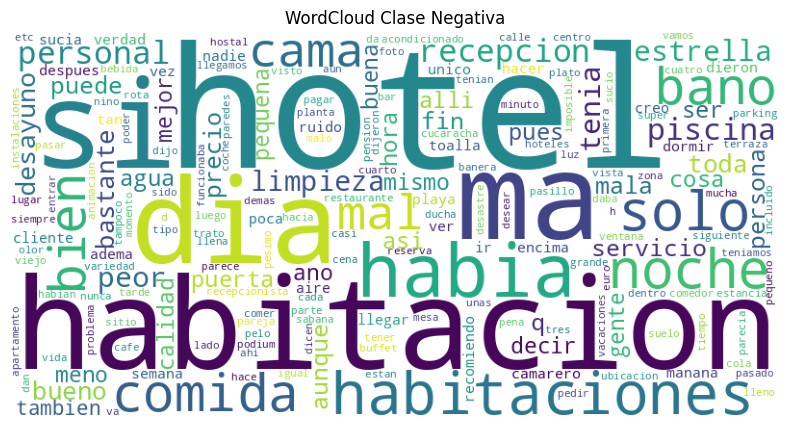

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# WordCloud para la Clase Negativa (0)
texto_unido_n = ' '.join(df[df['rank'] == 0]['review_tokenizado'].sum())
wordcloud_n = WordCloud( width=800, height=400, background_color='white', collocations=False).generate(texto_unido_n)

plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Negativa')
plt.imshow(wordcloud_n)
plt.axis('off')
plt.show()

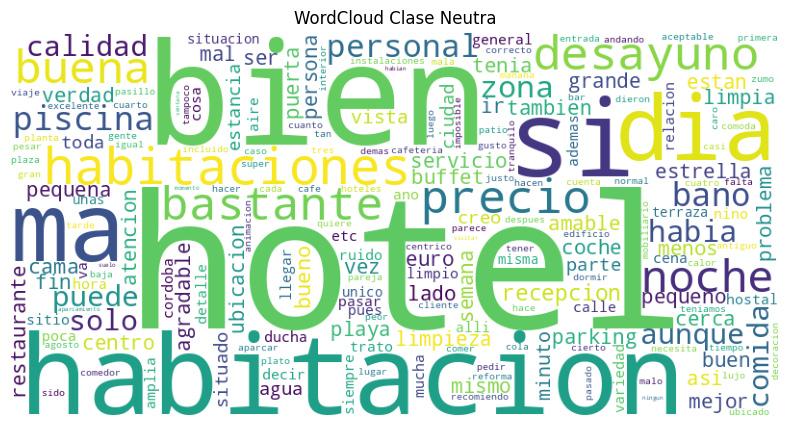

In [ ]:
# WordCloud para la Clase Neutra (1)
texto_unido_n = ' '.join(df[df['rank'] == 1]['review_tokenizado'].sum())
wordcloud_n = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(texto_unido_n)

plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Neutra')
plt.imshow(wordcloud_n)
plt.axis('off')
plt.show()

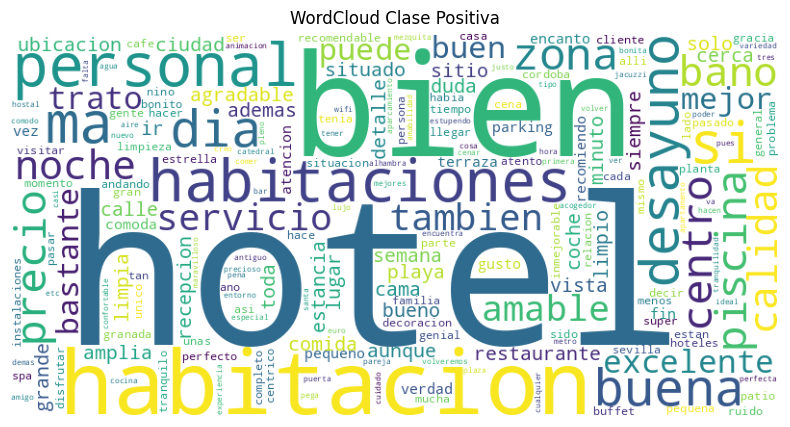

In [ ]:
# WordCloud para la Clase Positiva (2)
texto_unido_p = ' '.join(df[df['rank'] == 2]['review_tokenizado'].sum())
wordcloud_p = WordCloud( width=800, height=400, background_color='white', collocations=False).generate(texto_unido_p)
plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Positiva')
plt.imshow(wordcloud_p)
plt.axis('off')
plt.show()

Es importante distinguir que hay factores transversales, que  aparecen mencionados en todas las nubes de palabras. Ejemplos son "plato" o "comida" que se refieren a la calidad de ordenado por el cliente. Sin embargo, "atención" es clave, indicando que no solo es relevante para los comensales la calidad de la comida, sino también como son atendidos.

Adicionalmente, hay factores específicos negativos y positivos que solo aparecen en una de las nubes, tales como "caro" o "demoraron" en la negativa o "rico/a", "ambiente" o "variedad" en la positiva. Aquí hay factores nuevos que van más allá de la comida misma y la atención que son relevantes en la calidad de servicio.
Estos factores son importantes para la máquina ya que les será más fácil identificarlos en una clase y no en la otra para identificar polaridad. Para los factores comunes, la máquina debe deducirlos del contexto y de los adjetivos calificativos que abundan en las nubes ("mal", "malo/a", "buen", etc.)


Veamos ahora los bigramas o conceptos basados en dos palabras:

## Bigramas


Un bigrama o digrama es un grupo de dos letras, dos sílabas, o dos palabras. Los bigramas son utilizados comúnmente como base para el simple análisis estadístico de texto. Se utilizan en uno de los más exitosos modelos de lenguaje para el reconocimiento de voz.

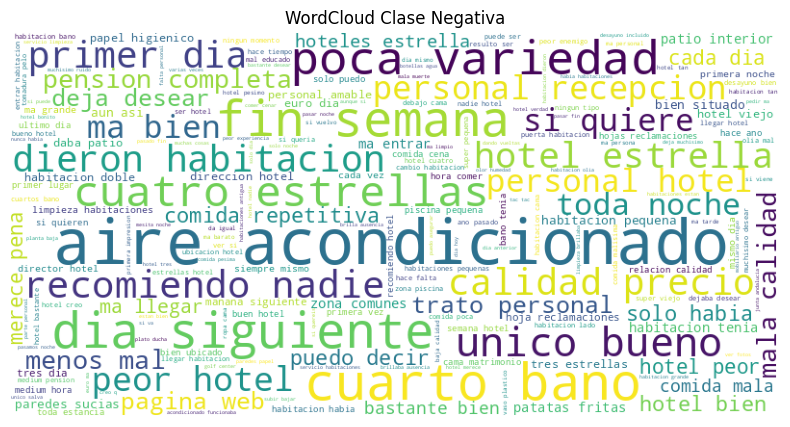

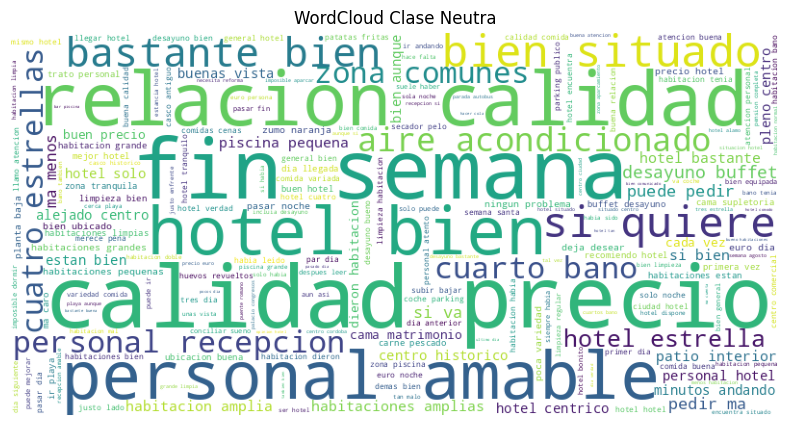

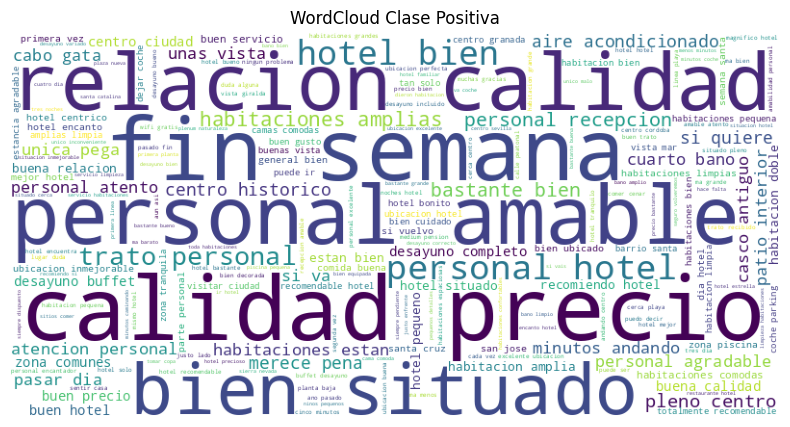

In [ ]:
# Clase Negativa (0)
texto_unido_n = ' '.join(df[df['rank'] == 0]['review_tokenizado'].sum())
wordcloud_n = WordCloud(width=800, height=400, background_color='white', collocation_threshold = 3).generate(texto_unido_n)
plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Negativa')
plt.imshow(wordcloud_n)
plt.axis('off')
plt.show()

# Clase Negativa (1)
texto_unido_n = ' '.join(df[df['rank'] == 1]['review_tokenizado'].sum())
wordcloud_n = WordCloud(width=800, height=400, background_color='white', collocation_threshold = 3).generate(texto_unido_n)
plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Neutra')
plt.imshow(wordcloud_n)
plt.axis('off')
plt.show()

# Clase Positiva (2)
texto_unido_p = ' '.join(df[df['rank'] == 2]['review_tokenizado'].sum())
wordcloud_p = WordCloud( width=800, height=400, background_color='white', collocation_threshold = 3).generate(texto_unido_p)
plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Positiva')
plt.imshow(wordcloud_p)
plt.axis('off')
plt.show()

La nube de palabras de bigramas es capaz de distinguir claramente factores importantes detectados con unigramas al incorporar adjetivos calificativos. Por ejemplo, "atención", que aparecía en la nube negativa, neutra y positiva, ahora se distingue claramente como "mala" o "pésima" atención en la nube de bigramas negativos, y "buena" o "excelente" atención en la nube de bigramas positivos. Esto es clave, ya que las máquinas hasta antes de aprendizaje profundo se enfocaban mucho en palabras independientes, y era más difícil reconocer contexto. Si una palabra como atención aparecía homogéneamente en las tres clases, entonces no era relevante. Los bigramas son entonces útiles para obtener más información.

Otra ventaja de los bigramas es que aparecen conceptos combinados que solo en su conjunto son relevantes y hacen sentido. Aparecen platos y tragos como "pisco sour" o "papas fritas", y se distinguen comidas de diferentes orígenes ("comida peruana" o "comida chilena").  

Para finalizar, guardamos la base de datos pre-procesada como archivo "pickle",que es un formato de Python adecuado para este tipo de estructuras secuenciales.

In [ ]:
# Guardar DataFrame como pickle
df.to_pickle('/content/gdrive/MyDrive/202520/ANALITICA TEXTUAL/T1/df_procesado.pkl')

# Para cargar
# df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/df_procesado.pkl')

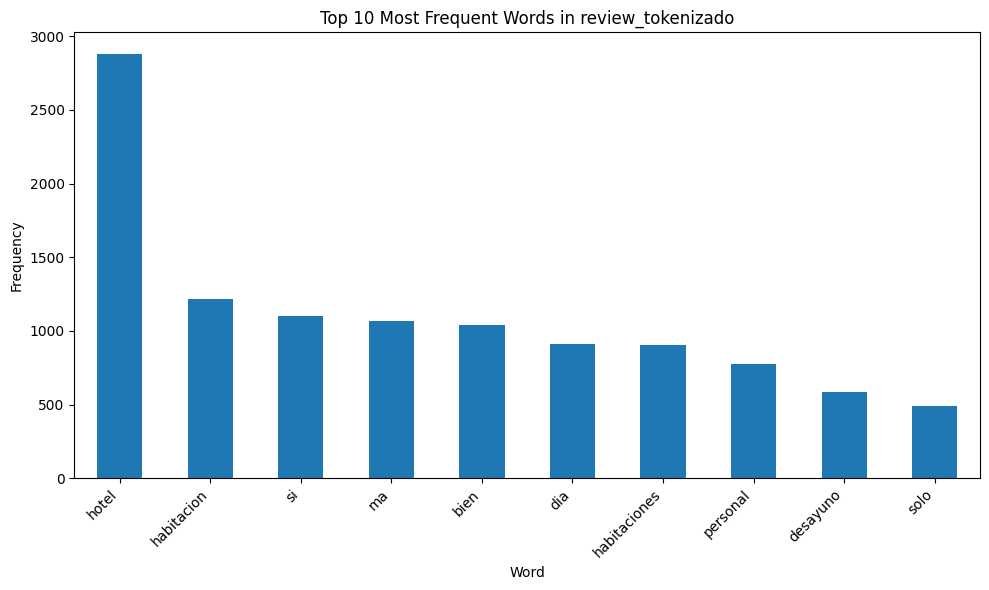

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten the list of lists in review_tokenizado
all_words = [word for sublist in df['review_tokenizado'] for word in sublist]

# Count the frequency of each word
word_counts = Counter(all_words)

# Get the top 10 most common words
top_10_words = word_counts.most_common(10)

# Create a pandas Series for easier plotting
top_10_series = pd.Series(dict(top_10_words))

# Create the bar chart
plt.figure(figsize=(10, 6))
top_10_series.plot(kind='bar')
plt.title('Top 10 Most Frequent Words in review_tokenizado')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Clasificación y comparación de modelos

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from scipy.sparse import hstack
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

df = pd.read_pickle('/content/gdrive/MyDrive/202520/ANALITICA TEXTUAL/T1/df_procesado.pkl')
df = df.reset_index(drop=True)

def join_if_list(x):
    if isinstance(x, list):
        return " ".join(map(str, x))
    return str(x)

for col in ["review_texto_final","abstract_texto_final",
            "review_tokenizado","abstract_tokenizado"]:
    if col in df.columns:
        df[col] = df[col].apply(join_if_list)

if {"review_texto_final","abstract_texto_final"}.issubset(df.columns):
    review_col, abstract_col = "review_texto_final", "abstract_texto_final"
    lemma_variant = True
elif {"review_tokenizado","abstract_tokenizado"}.issubset(df.columns):
    review_col, abstract_col = "review_tokenizado", "abstract_tokenizado"
    lemma_variant = False
else:
    raise ValueError("No se encontraron columnas de review/abstract esperadas.")

# 'rank' as the target column
target_col = 'rank'
if target_col not in df.columns:
     raise ValueError(f"No se encontró la columna de etiquetas '{target_col}'.")

y_raw = df[target_col]
if y_raw.dtype == "O" or str(y_raw.dtype).startswith("category"):
    le = LabelEncoder()
    y = le.fit_transform(y_raw)
    classes = list(le.classes_)
else:
    y = y_raw.values
    classes = sorted(pd.Series(y).unique().tolist())

print("🔄 Dividiendo en train/test...")
idx_train, idx_test = train_test_split(
    np.arange(len(df)),
    test_size=0.2,
    random_state=42,
    stratify=y
)

def build_vectorizer():
    return TfidfVectorizer(strip_accents="unicode",
                           lowercase=True,
                           ngram_range=(1,2),
                           min_df=1)

def build_vectorizer_char():
    return TfidfVectorizer(analyzer="char",
                           ngram_range=(3,5),
                           min_df=1)

def get_models():
    return {
        "LogReg": LogisticRegression(max_iter=200),
        "NaiveBayes": MultinomialNB(),
        "DecisionTree": DecisionTreeClassifier(random_state=42),
        "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
        "NeuralNet": MLPClassifier(hidden_layer_sizes=(128,), max_iter=50, random_state=42),
        "LinearSVM": LinearSVC()
    }

def evaluate_models(X_train, X_test, y_train, y_test, scenario):
    print(f"\n🚀 Entrenando y evaluando modelos para escenario: {scenario}")
    results, reports = [], {}
    for name, model in tqdm(get_models().items(), desc=f"Modelos {scenario}"):
        pipe = Pipeline([("clf", model)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
            y_test, y_pred, average="macro", zero_division=0
        )
        prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
            y_test, y_pred, average="weighted", zero_division=0
        )

        results.append({
            "Scenario": scenario,
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision_macro": prec_macro,
            "Recall_macro": rec_macro,
            "F1_macro": f1_macro,
            "Precision_weighted": prec_w,
            "Recall_weighted": rec_w,
            "F1_weighted": f1_w
        })
        reports[name] = classification_report(y_test, y_pred, zero_division=0)
    return pd.DataFrame(results), reports

def run_scenario(text_train, text_test, scenario_name):
    vw, vc = build_vectorizer(), build_vectorizer_char()
    Xw_tr = vw.fit_transform(text_train)
    Xw_te = vw.transform(text_test)
    Xc_tr = vc.fit_transform(text_train)
    Xc_te = vc.transform(text_test)
    return evaluate_models(hstack([Xw_tr, Xc_tr]),
                           hstack([Xw_te, Xc_te]),
                           y[idx_train], y[idx_test],
                           scenario_name)

print("\n=== Escenario 1: Solo Review ===")
res_review, rep_review = run_scenario(
    df.iloc[idx_train][review_col].fillna(""),
    df.iloc[idx_test][review_col].fillna(""),
    "Review only"
)

res_abs, rep_abs = run_scenario(
    df.iloc[idx_train][abstract_col].fillna(""),
    df.iloc[idx_test][abstract_col].fillna(""),
    "Abstract only"
)

print("\n=== Escenario 3: Review + Abstract ===")
rvw, rvc = build_vectorizer(), build_vectorizer_char()
avw, avc = build_vectorizer(), build_vectorizer_char()

print("Vectorizando Review...")
Rw_tr = rvw.fit_transform(df.iloc[idx_train][review_col].fillna(""))
Rw_te = rvw.transform(df.iloc[idx_test][review_col].fillna(""))
Rc_tr = rvc.fit_transform(df.iloc[idx_train][review_col].fillna(""))
Rc_te = rvc.transform(df.iloc[idx_test][review_col].fillna(""))

print("Vectorizando Abstract...")
Aw_tr = avw.fit_transform(df.iloc[idx_train][abstract_col].fillna(""))
Aw_te = avw.transform(df.iloc[idx_test][abstract_col].fillna(""))
Ac_tr = avc.fit_transform(df.iloc[idx_train][abstract_col].fillna(""))
Ac_te = avc.transform(df.iloc[idx_test][abstract_col].fillna(""))

print("Entrenando modelos combinados...")
X_comb_tr = hstack([Rw_tr, Rc_tr, Aw_tr, Ac_tr])
X_comb_te = hstack([Rw_te, Rc_te, Aw_te, Ac_te])
res_comb, rep_comb = evaluate_models(X_comb_tr, X_comb_te,
                                     y[idx_train], y[idx_test],
                                     "Review + Abstract")


out_dir = Path("/content/gdrive/MyDrive/202520/ANALITICA TEXTUAL/T1")
out_dir.mkdir(exist_ok=True, parents=True)

results = pd.concat([res_review, res_abs, res_comb], ignore_index=True)
results.to_csv(out_dir / "model_metrics_all_scenarios.csv", index=False)

reports_txt = [f"Classes: {classes}\n\n"]
for scen, repdict in [("Review only", rep_review),
                      ("Abstract only", rep_abs),
                      ("Review + Abstract", rep_comb)]:
    reports_txt.append(f"===== {scen} =====\n")
    for model_name, rep in repdict.items():
        reports_txt.append(f"\n--- {model_name} ---\n{rep}\n")

with open(out_dir / "classification_reports.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(reports_txt))

print("CSV de métricas:", out_dir / "model_metrics_all_scenarios.csv")
print("Reportes detallados:", out_dir / "classification_reports.txt")

Mounted at /content/gdrive
🔄 Cargando DataFrame procesado...
✅ DataFrame cargado con 1815 filas.
🔄 Codificando etiquetas...
✅ Etiquetas codificadas: [0, 1, 2]
🔄 Dividiendo en train/test...
✅ Train: 1452 | Test: 363

=== Escenario 1: Solo Review ===

🚀 Entrenando y evaluando modelos para escenario: Review only


Modelos Review only: 100%|██████████| 6/6 [05:17<00:00, 52.92s/it]



🚀 Entrenando y evaluando modelos para escenario: Abstract only


Modelos Abstract only: 100%|██████████| 6/6 [00:46<00:00,  7.76s/it]



=== Escenario 3: Review + Abstract ===
Vectorizando Review...
Vectorizando Abstract...
Entrenando modelos combinados...

🚀 Entrenando y evaluando modelos para escenario: Review + Abstract


Modelos Review + Abstract: 100%|██████████| 6/6 [04:58<00:00, 49.69s/it]


💾 Guardando resultados...
✅ CSV de métricas: /content/gdrive/MyDrive/202520/ANALITICA TEXTUAL/T1/model_metrics_all_scenarios.csv
✅ Reportes detallados: /content/gdrive/MyDrive/202520/ANALITICA TEXTUAL/T1/classification_reports.txt
🎯 Proceso finalizado.


Análisis de la influencia de la lematización

In [ ]:
print("\n=== Comparando versión lematizada vs. no lematizada ===")

has_lemma = {"review_texto_final", "abstract_texto_final"}.issubset(df.columns)
has_token = {"review_tokenizado", "abstract_tokenizado"}.issubset(df.columns)

if has_lemma and has_token:
    # Lematizados
    res_lemma_review, _ = run_scenario(
        df.iloc[idx_train]["review_texto_final"].fillna(""),
        df.iloc[idx_test]["review_texto_final"].fillna(""),
        "Review only (lemmatized)"
    )
    res_lemma_abs, _ = run_scenario(
        df.iloc[idx_train]["abstract_texto_final"].fillna(""),
        df.iloc[idx_test]["abstract_texto_final"].fillna(""),
        "Abstract only (lemmatized)"
    )

    # Tokenizados
    res_tok_review, _ = run_scenario(
        df.iloc[idx_train]["review_tokenizado"].fillna(""),
        df.iloc[idx_test]["review_tokenizado"].fillna(""),
        "Review only (tokenized)"
    )
    res_tok_abs, _ = run_scenario(
        df.iloc[idx_train]["abstract_tokenizado"].fillna(""),
        df.iloc[idx_test]["abstract_tokenizado"].fillna(""),
        "Abstract only (tokenized)"
    )

    lemma_results = pd.concat([res_lemma_review, res_lemma_abs], ignore_index=True)
    token_results = pd.concat([res_tok_review, res_tok_abs], ignore_index=True)

    comp_results = pd.concat([lemma_results.assign(Variant="Lemmatized"),
                              token_results.assign(Variant="Tokenized")],
                             ignore_index=True)

    comp_path = out_dir / "comparison_lemma_vs_token.csv"
    comp_results.to_csv(comp_path, index=False)
    print("Resultados comparativos guardados en:", comp_path)

else:
    print("No se encontraron ambas versiones (lematizada y tokenizada) en el DataFrame.")


=== Comparando versión lematizada vs. no lematizada ===

🚀 Entrenando y evaluando modelos para escenario: Review only (lemmatized)


Modelos Review only (lemmatized): 100%|██████████| 6/6 [05:17<00:00, 52.99s/it]



🚀 Entrenando y evaluando modelos para escenario: Abstract only (lemmatized)


Modelos Abstract only (lemmatized): 100%|██████████| 6/6 [00:46<00:00,  7.76s/it]



🚀 Entrenando y evaluando modelos para escenario: Review only (tokenized)


Modelos Review only (tokenized): 100%|██████████| 6/6 [04:48<00:00, 48.07s/it]



🚀 Entrenando y evaluando modelos para escenario: Abstract only (tokenized)


Modelos Abstract only (tokenized): 100%|██████████| 6/6 [00:50<00:00,  8.50s/it]

✅ Resultados comparativos guardados en: /content/gdrive/MyDrive/202520/ANALITICA TEXTUAL/T1/comparison_lemma_vs_token.csv


Comparación de los resultados del escenario “Review only”

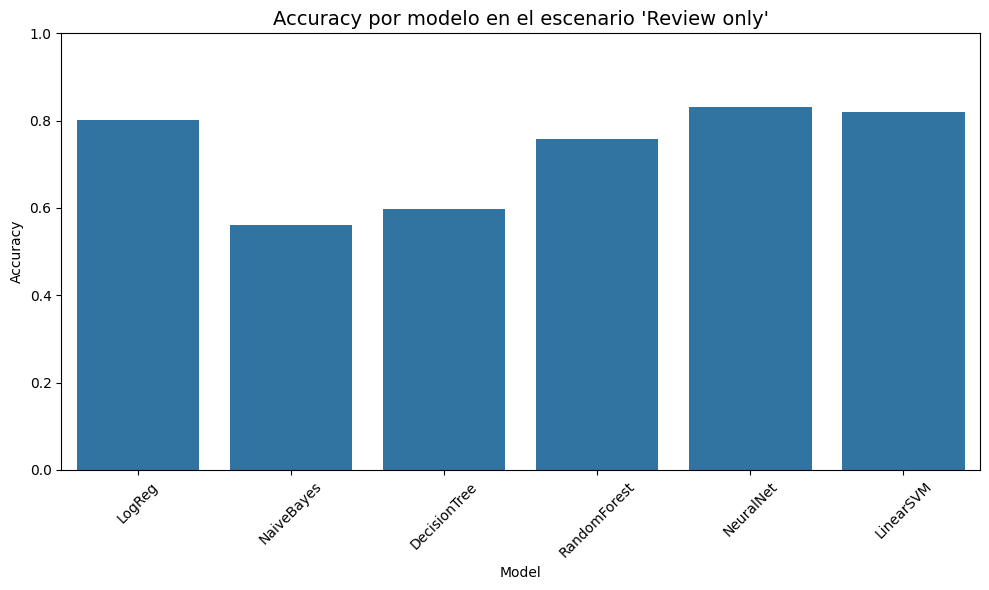

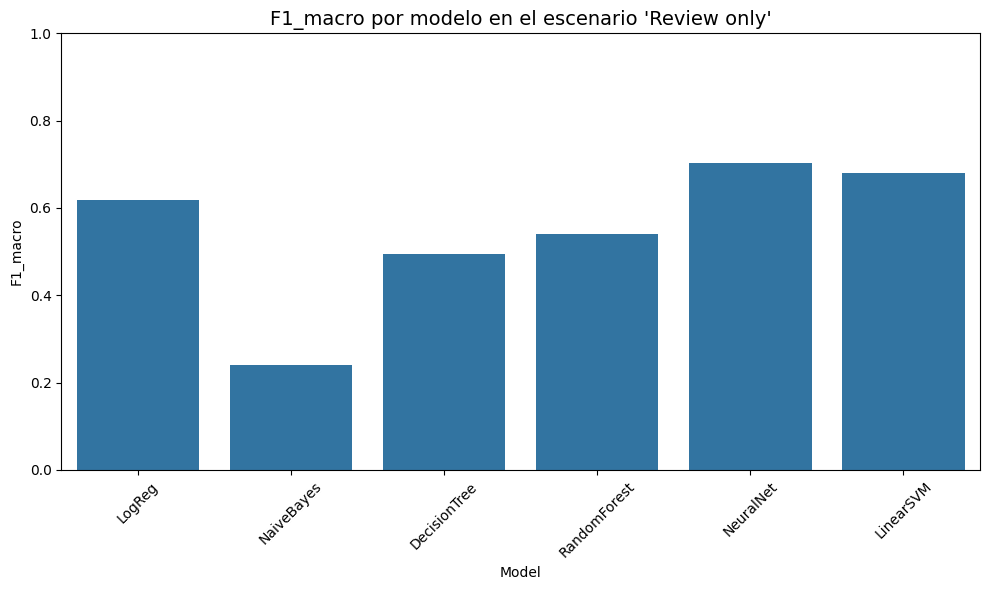

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_metrics = pd.read_csv(out_dir / "model_metrics_all_scenarios.csv")

df_review_only = df_metrics[df_metrics["Scenario"] == "Review only"]

df_plot = df_review_only[["Scenario", "Model", "Accuracy", "F1_macro"]]

# Gráfico Accuracy por modelo en el escenario "Review only"
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x="Model", y="Accuracy")
plt.title("Accuracy por modelo en el escenario 'Review only'", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# Gráfico F1_macro por modelo en el escenario "Review only"
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x="Model", y="F1_macro")
plt.title("F1_macro por modelo en el escenario 'Review only'", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.ylabel("F1_macro")
plt.tight_layout()
plt.show()

Comparación de Escenarios (Review, Abstract, Review+Abstract)

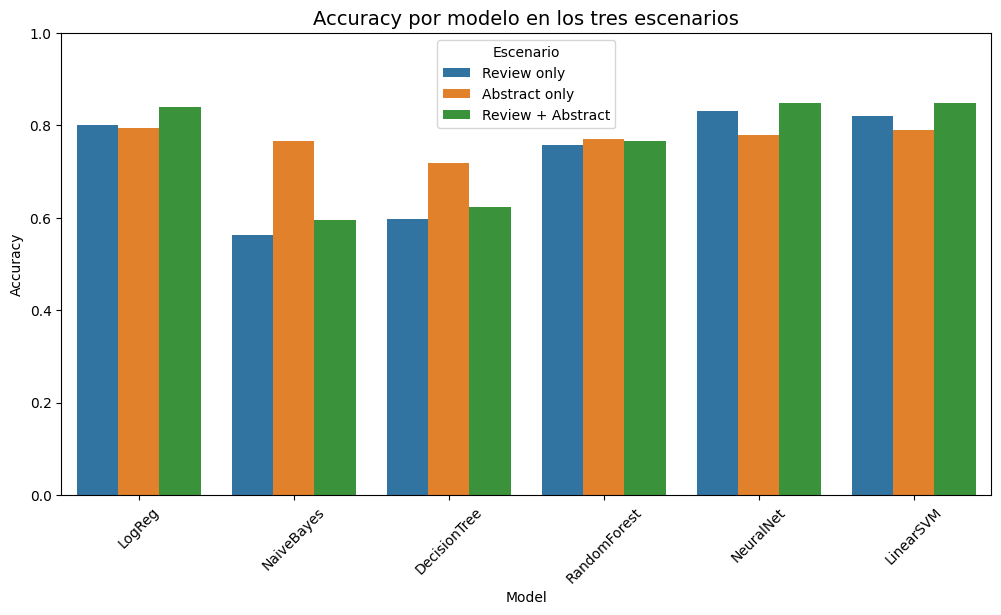

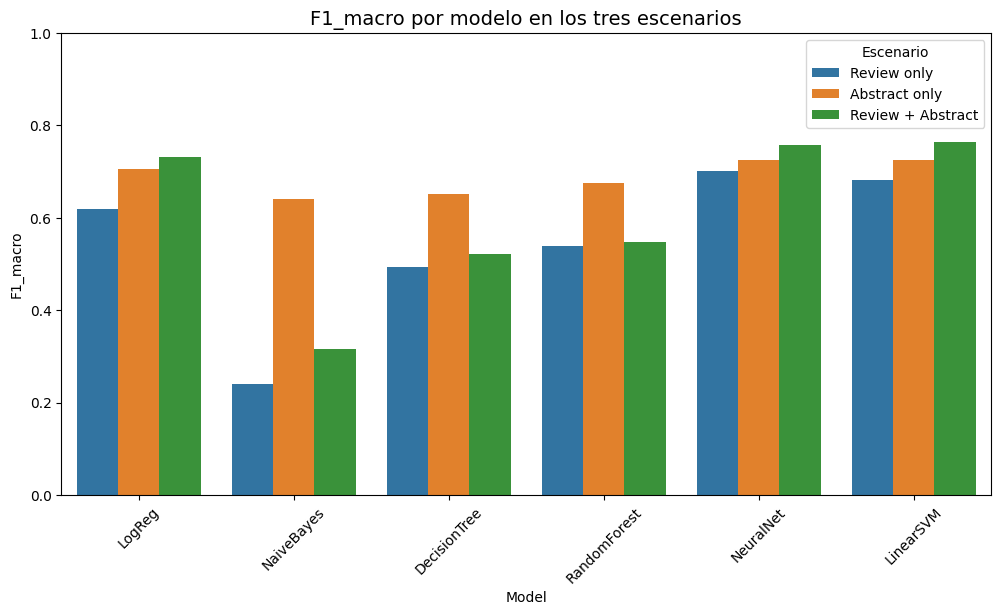

In [ ]:
df_plot = df_metrics[["Scenario", "Model", "Accuracy", "F1_macro"]]

# Gráfico Accuracy por escenario y modelo
plt.figure(figsize=(12,6))
sns.barplot(data=df_plot, x="Model", y="Accuracy", hue="Scenario")
plt.title("Accuracy por modelo en los tres escenarios", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.legend(title="Escenario")
plt.show()

# Gráfico F1_macro por escenario y modelo
plt.figure(figsize=(12,6))
sns.barplot(data=df_plot, x="Model", y="F1_macro", hue="Scenario")
plt.title("F1_macro por modelo en los tres escenarios", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.legend(title="Escenario")
plt.show()

Comparación Lematización vs Tokenización

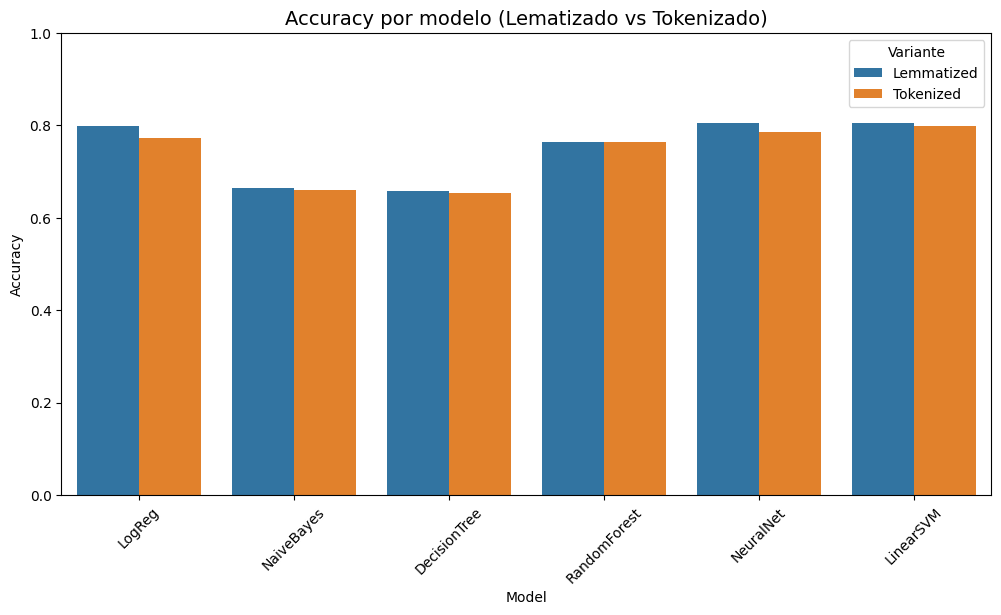

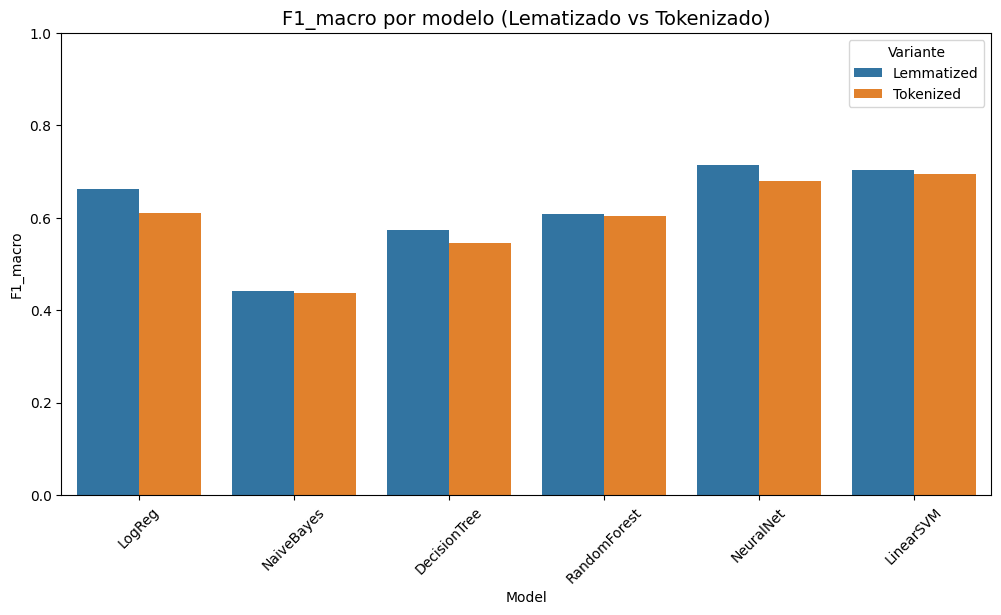

In [ ]:
df_comp = pd.read_csv(out_dir / "comparison_lemma_vs_token.csv")

df_comp_plot = df_comp[["Scenario", "Model", "Accuracy", "F1_macro", "Variant"]]

# Gráfico Accuracy
plt.figure(figsize=(12,6))
sns.barplot(data=df_comp_plot, x="Model", y="Accuracy", hue="Variant", errorbar=None)
plt.title("Accuracy por modelo (Lematizado vs Tokenizado)", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.legend(title="Variante")
plt.show()

# Gráfico F1_macro
plt.figure(figsize=(12,6))
sns.barplot(data=df_comp_plot, x="Model", y="F1_macro", hue="Variant", errorbar=None)
plt.title("F1_macro por modelo (Lematizado vs Tokenizado)", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.legend(title="Variante")
plt.show()

Heatmap de Accuracy por Modelo y Escenario

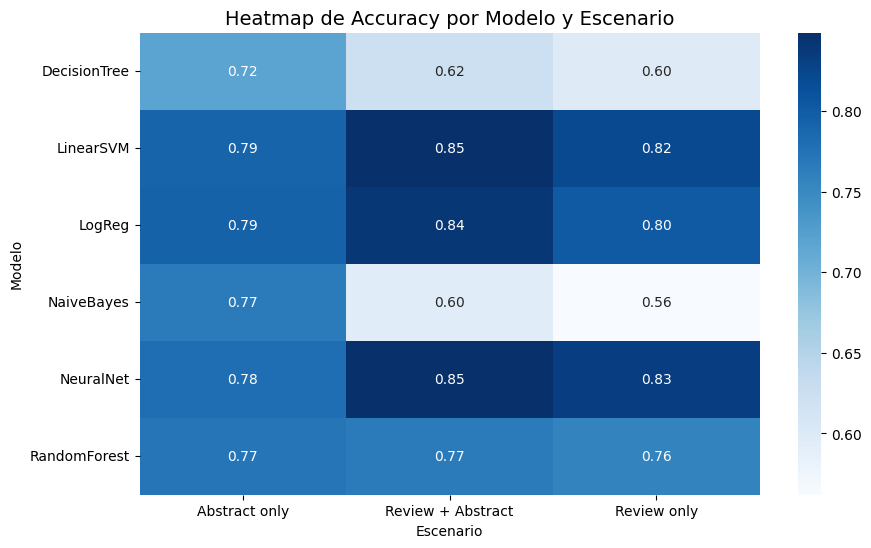

In [ ]:
pivot_acc = df_metrics.pivot(index="Model", columns="Scenario", values="Accuracy")

plt.figure(figsize=(10,6))
sns.heatmap(pivot_acc, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Heatmap de Accuracy por Modelo y Escenario", fontsize=14)
plt.ylabel("Modelo")
plt.xlabel("Escenario")
plt.show()

Heatmap de F1 Macro por Modelo y Escenario

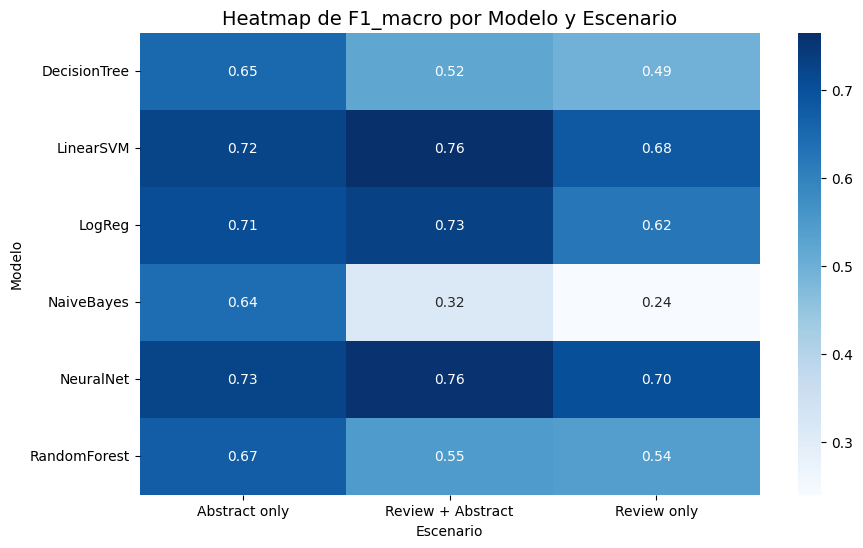

In [ ]:
pivot_f1 = df_metrics.pivot(index="Model", columns="Scenario", values="F1_macro")

plt.figure(figsize=(10,6))
sns.heatmap(pivot_f1, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Heatmap de F1_macro por Modelo y Escenario", fontsize=14)
plt.ylabel("Modelo")
plt.xlabel("Escenario")
plt.show()